# Zero-shot Image Classification : CLIP

## CLIP

**CLIP(Constrastive Language-Image Pre-training)**
- Learning associations between images and text

**CLIP Processor**

In [2]:
from datasets import load_dataset
from transformers import CLIPProcessor, CLIPModel

In [3]:
model_name = "openai/clip-vit-base-patch32"

processor = CLIPProcessor.from_pretrained(model_name)
model = CLIPModel.from_pretrained(model_name)

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

In [4]:
dataset = load_dataset("sasha/dog-food")

README.md:   0%|          | 0.00/4.37k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

dataset_infos.json:   0%|          | 0.00/1.12k [00:00<?, ?B/s]

(…)-00000-of-00001-9bf5abf8b080cbba.parquet:   0%|          | 0.00/199M [00:00<?, ?B/s]

(…)-00000-of-00001-6ea6ccdcc8fa38d5.parquet:   0%|          | 0.00/85.8M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/2100 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/900 [00:00<?, ? examples/s]

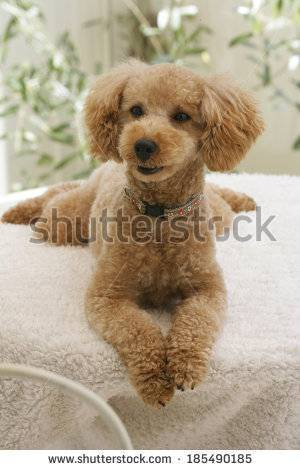

In [8]:
dataset["train"]["image"][0]

In [9]:
images = dataset["test"]["image"][:2]
labels = ["dog", "food"]

inputs = processor(images=images, text=labels, return_tensors="pt") # padding=True

In [11]:
inputs.keys()

dict_keys(['input_ids', 'attention_mask', 'pixel_values'])

In [12]:
print("input_ids :", inputs["input_ids"])
print("attention_mask :", inputs["attention_mask"])
print("pixel_values :", inputs["pixel_values"])
print("image_shape :", inputs["pixel_values"].shape)

input_ids : tensor([[49406,  1929, 49407],
        [49406,  1559, 49407]])
attention_mask : tensor([[1, 1, 1],
        [1, 1, 1]])
pixel_values : tensor([[[[-0.0113, -0.0988, -0.1426,  ...,  0.1347,  0.1055,  0.0909],
          [ 0.0471, -0.0113, -0.0405,  ...,  0.1347,  0.1055,  0.0909],
          [ 0.1347,  0.1055,  0.0909,  ...,  0.1493,  0.0909,  0.0909],
          ...,
          [-0.3032, -0.2448, -0.3178,  ..., -0.1426, -0.8288,  0.0617],
          [-0.4492, -0.4054, -0.2886,  ..., -0.5514, -0.6390, -0.3762],
          [-0.3762, -0.5222, -0.4784,  ..., -0.9164, -1.0623, -0.0113]],

         [[ 0.2740,  0.1689,  0.0939,  ..., -0.2813, -0.3114, -0.3264],
          [ 0.3490,  0.2589,  0.2139,  ..., -0.2813, -0.3114, -0.3264],
          [ 0.4390,  0.3940,  0.3490,  ..., -0.2813, -0.3264, -0.3264],
          ...,
          [-1.2869, -1.2118, -1.1968,  ..., -0.8216, -1.3919, -0.5065],
          [-1.4219, -1.3469, -1.1818,  ..., -1.1968, -1.2718, -1.0918],
          [-1.3319, -1.4369, -

**Zero-shot image classification**

In [13]:
import torch

In [14]:
model.eval()

with torch.no_grad():
    outputs = model(**inputs)
    logits_per_image = outputs.logits_per_image
    probs = logits_per_image.softmax(dim=-1)

    print("outputs = ", outputs.keys())
    print("logits_per_image = ", logits_per_image)
    print("probs = ", probs)

for idx, prob in enumerate(probs):
    print(f"- Image #{idx}")
    for label, p in zip(labels, prob):
        print(f"{label} : {p:.4f}")

outputs =  odict_keys(['logits_per_image', 'logits_per_text', 'text_embeds', 'image_embeds', 'text_model_output', 'vision_model_output'])
logits_per_image =  tensor([[23.3881, 18.8604],
        [24.8627, 21.5765]])
probs =  tensor([[0.9893, 0.0107],
        [0.9640, 0.0360]])
- Image #0
dog : 0.9893
food : 0.0107
- Image #1
dog : 0.9640
food : 0.0360


**Evaluation image classification model**

In [15]:
import evaluate
from torch.utils.data import DataLoader

In [17]:
test_dataloader = DataLoader(
    dataset["test"],
    batch_size=8,
    collate_fn=lambda batch: (
        [item["image"] for item in batch],
        [item["label"] for item in batch]
    )
)

In [23]:
metric = evaluate.load("accuracy")
predictions, references = [], []
labels_names = dataset["test"].features["label"].names

Using the latest cached version of the module from /root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--accuracy/f887c0aab52c2d38e1f8a215681126379eca617f96c447638f751434e8e65b14 (last modified on Fri Nov  1 07:38:32 2024) since it couldn't be found locally at evaluate-metric--accuracy, or remotely on the Hugging Face Hub.


In [30]:
model.eval()

with torch.no_grad():
    for images, labels in test_dataloader:
        inputs = processor(images=images, text=labels_names, return_tensors="pt")
        outputs = model(**inputs)
        probs = outputs.logits_per_image.softmax(dim=-1)

        predictions += probs.argmax(dim=-1).cpu().tolist()
        references += labels

In [38]:
results = metric.compute(predictions=predictions, references=references)

In [46]:
print(f"클래스 목록 : {labels_names}")
print(f"정확도 : {results['accuracy'] * 100 :.2f}%")

클래스 목록 : ['dog', 'food']
정확도 : 99.78%


# Zero-shot Object Detection : OWLv2

## OWLv2

**OWL-ViT(Vision Transformer for Open-World Localization)**

**Initialize OWLv2 & Load dataset**

In [47]:
import io
from PIL import Image
from datasets import load_dataset
from transformers import Owlv2ForObjectDetection, Owlv2Processor

In [48]:
model_name = "google/owlv2-base-patch16"

processor = Owlv2Processor.from_pretrained(model_name)
model =Owlv2ForObjectDetection.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/425 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/67.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/121 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/414 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/620M [00:00<?, ?B/s]

In [49]:
dataset = load_dataset("Francesco/animals-ij5d2")

README.md:   0%|          | 0.00/3.54k [00:00<?, ?B/s]

(…)-00000-of-00001-83ef17440fd25f6f.parquet:   0%|          | 0.00/33.6M [00:00<?, ?B/s]

(…)-00000-of-00001-876de533d76d48c6.parquet:   0%|          | 0.00/4.90M [00:00<?, ?B/s]

(…)-00000-of-00001-77e7809ef7ac5cc0.parquet:   0%|          | 0.00/10.1M [00:00<?, ?B/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [50]:
print(dataset)
print(dataset["test"][0])

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 700
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 200
    })
})
{'image_id': 63, 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7C684D75E260>, 'width': 640, 'height': 640, 'objects': {'id': [96, 97, 98, 99], 'area': [138029, 8508, 10150, 20624], 'bbox': [[129.0, 291.0, 395.5, 349.0], [119.0, 266.0, 93.5, 91.0], [296.0, 280.0, 116.0, 87.5], [473.0, 284.0, 167.0, 123.5]], 'category': [3, 3, 3, 3]}}


**Preprocess using OWLv2 processor**

In [56]:
images = dataset["test"]["image"][:2]
categories = dataset["test"].features["objects"].feature["category"].names
labels = [categories] * len(images)
inputs = processor(text=labels, images=images, return_tensors="pt", padding=True)

In [57]:
print(images)

[<PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7C684D792050>, <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640 at 0x7C684D7921D0>]


In [58]:
print(labels)

[['animals', 'cat', 'chicken', 'cow', 'dog', 'fox', 'goat', 'horse', 'person', 'racoon', 'skunk'], ['animals', 'cat', 'chicken', 'cow', 'dog', 'fox', 'goat', 'horse', 'person', 'racoon', 'skunk']]


In [60]:
inputs["input_ids"]

tensor([[49406,  4995, 49407,     0],
        [49406,  2368, 49407,     0],
        [49406,  3717, 49407,     0],
        [49406,  9706, 49407,     0],
        [49406,  1929, 49407,     0],
        [49406,  3240, 49407,     0],
        [49406,  9530, 49407,     0],
        [49406,  4558, 49407,     0],
        [49406,  2533, 49407,     0],
        [49406,  1773,  7100, 49407],
        [49406, 42194, 49407,     0],
        [49406,  4995, 49407,     0],
        [49406,  2368, 49407,     0],
        [49406,  3717, 49407,     0],
        [49406,  9706, 49407,     0],
        [49406,  1929, 49407,     0],
        [49406,  3240, 49407,     0],
        [49406,  9530, 49407,     0],
        [49406,  4558, 49407,     0],
        [49406,  2533, 49407,     0],
        [49406,  1773,  7100, 49407],
        [49406, 42194, 49407,     0]])

In [61]:
inputs["attention_mask"]

tensor([[1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 1],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 0],
        [1, 1, 1, 1],
        [1, 1, 1, 0]])

In [62]:
inputs["pixel_values"].size()

torch.Size([2, 3, 960, 960])

**Inference zero-shot object detection**

In [63]:
import torch

In [64]:
model.eval()

with torch.no_grad():
    outputs = model(**inputs)

In [65]:
print(outputs.keys())

odict_keys(['logits', 'objectness_logits', 'pred_boxes', 'text_embeds', 'image_embeds', 'class_embeds', 'text_model_output', 'vision_model_output'])


In [66]:
outputs.logits.shape

torch.Size([2, 3600, 11])

In [67]:
outputs.objectness_logits.shape

torch.Size([2, 3600])

In [68]:
outputs.pred_boxes.shape

torch.Size([2, 3600, 4])

In [69]:
outputs.class_embeds.shape

torch.Size([2, 3600, 512])

**object selection**

In [77]:
shape = [dataset["test"][:2]["width"], dataset["test"][:2]["height"]]
target_sizes = list(map(list, zip(*shape)))
detections = processor.post_process_object_detection(
    outputs=outputs, threshold=0.5, target_sizes=target_sizes
)

In [78]:
print(target_sizes)
print(detections)

[[640, 640], [640, 640]]
[{'scores': tensor([0.5499, 0.6243, 0.6733]), 'labels': tensor([3, 3, 3]), 'boxes': tensor([[329.0246, 287.1844, 400.3371, 357.9262],
        [122.9359, 272.8752, 534.3259, 637.6506],
        [479.7363, 294.2745, 636.4860, 396.8372]])}, {'scores': tensor([0.7538]), 'labels': tensor([7]), 'boxes': tensor([[ -0.7799, 173.7043, 440.0295, 538.7166]])}]


**Visualization**

In [79]:
import matplotlib.pyplot as plt
from PIL import ImageDraw, ImageFont

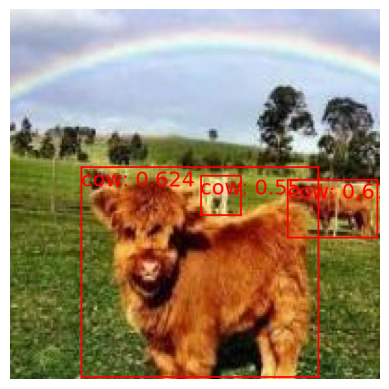

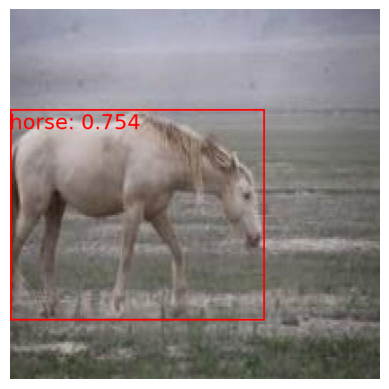

In [90]:
for idx, (image, detect) in enumerate(zip(images, detections)):
    im = image.copy()
    draw = ImageDraw.Draw(im)
    font = ImageFont.truetype("DejaVuSans.ttf", 36)

    for box, score, label in zip(detect["boxes"], detect["scores"], detect["labels"]):
        box = [round(i, 2) for i in box.tolist()]
        draw.rectangle(box, outline="red", width=3)

        label_text = f"{labels[idx][label]}: {round(score.item(), 3)}"
        draw.text((box[0], box[1]), label_text, fill="red", font=font)

    plt.imshow(im)
    plt.axis("off")
    plt.show()

**Translation format to COCO**

In [94]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 700
    })
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 100
    })
    test: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 200
    })
})

In [99]:
dataset["train"][0]

{'image_id': 598,
 'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=640x640>,
 'width': 640,
 'height': 640,
 'objects': {'id': [922],
  'area': [256868],
  'bbox': [[2.0, 64.0, 464.5, 553.0]],
  'category': [1]}}

In [100]:
def get_coco_annotations(dataset):
    annotations = []
    for data in dataset:
        image_id = int(data["image_id"])
        objects = data["objects"]
        for idx in range(len(objects["id"])):
            annotations.append(
                {
                    "image_id": image_id,
                    "category_id": int(objects["category"][idx]),
                    "bbox": [float(coord) for coord in objects["bbox"][idx]],
                    "area": float(objects["area"][idx]),
                    "id": int(objects["id"][idx]),
                    "iscrowd": 0
                }
            )
    return annotations

In [101]:
coco_annotations = get_coco_annotations(dataset["test"])

In [103]:
coco_annotation_format = {
    "annotations": coco_annotations,
    "images": [{"id": int(data["image_id"])} for data in dataset["test"]],
    "categories": [{"id": i, "name": name} for i, name in enumerate(categories)]
}

In [104]:
print(len(coco_annotations))

351


In [105]:
coco_annotation_format["annotations"][0]

{'image_id': 63,
 'category_id': 3,
 'bbox': [129.0, 291.0, 395.5, 349.0],
 'area': 138029.0,
 'id': 96,
 'iscrowd': 0}

**Translation inference result to COCO format**

In [106]:
from torch.utils.data import DataLoader

In [107]:
dataloader = DataLoader(
    dataset["test"],
    batch_size=2,
    collate_fn=lambda batch: (
        [item["image"] for item in batch],
        [list(item["image"].size) for item in batch],
        [item["image_id"] for item in batch],
        [item["objects"] for item in batch]
    )
)

In [112]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

predictions = []

model.eval()

with torch.no_grad():
    for images, target_sizes, image_ids, objects in dataloader:
        input_labels = [categories] * len(images)
        inputs = processor(images=images, text=input_labels, return_tensors="pt")
        outputs = model(**inputs.to(device))
        detections = processor.post_process_object_detection(
            outputs=outputs, threshold=0.3, target_sizes=target_sizes
        )

        for batch_idx, detection in enumerate(detections):
            category_ids = detection["labels"].cpu().numpy().tolist()
            scores = detection["scores"].cpu().numpy().tolist()
            boxes = detection["boxes"].cpu().numpy()

            boxes[:, 2:4] -= boxes[:, :2]
            boxes = boxes.tolist()

            for obj_idx, box in enumerate(boxes):
                prediction = {
                    "image_id": image_ids[batch_idx],
                    "category_id": category_ids[obj_idx],
                    "bbox": box,
                    "score": scores[obj_idx]
                }
                predictions.append(prediction)

In [113]:
print(len(predictions))
print(predictions[0])

384
{'image_id': 63, 'category_id': 3, 'bbox': [329.024658203125, 287.1844787597656, 71.3125, 70.74172973632812], 'score': 0.5499141216278076}


**Evaluation**

In [114]:
from pycocotools.coco import COCO
from pycocotools.cocoeval import COCOeval

In [115]:
coco_gt = COCO()
coco_gt.dataset = coco_annotation_format
coco_gt.createIndex()

creating index...
index created!


In [118]:
coco_dt = coco_gt.loadRes(predictions)

Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!


In [122]:
coco_eval = COCOeval(coco_gt, coco_dt, "bbox")

In [123]:
coco_eval.evaluate()

Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.08s).


In [124]:
coco_eval.accumulate()

Accumulating evaluation results...
DONE (t=0.05s).


In [125]:
coco_eval.summarize()

 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.516
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets=100 ] = 0.656
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets=100 ] = 0.576
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.050
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.192
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.527
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=  1 ] = 0.455
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.579
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=   all | maxDets=100 ] = 0.581
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= small | maxDets=100 ] = 0.100
 Average Recall     (AR) @[ IoU=0.50:0.95 | area=medium | maxDets=100 ] = 0.230
 Average Recall     (AR) @[ IoU=0.50:0.95 | area= large | maxDets=100 ] = 0.590


# Image Segmentation : SAM

## SAM

**SAM(Segment Anything Model)**

**Initialize SAM**

In [126]:
import io
from PIL import Image
from datasets import load_dataset
from transformers import SamProcessor, SamModel

In [127]:
def filter_category(data):
    # 16 = dog, 23 = giraffe
    return 16 in data["objects"]["category"] or 23 in data["objects"]["category"]

def convert_image(data):
    byte = io.BytesIO(data["image"]["bytes"])
    img = Image.open(byte)
    return {"img": img}

In [128]:
model_name = "facebook/sam-vit-base"

processor = SamProcessor.from_pretrained(model_name)
model = SamModel.from_pretrained(model_name)

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/375M [00:00<?, ?B/s]

In [129]:
dataset = load_dataset("s076923/coco-val")

README.md:   0%|          | 0.00/30.0 [00:00<?, ?B/s]

val.parquet:   0%|          | 0.00/404M [00:00<?, ?B/s]

Generating validation split:   0%|          | 0/2476 [00:00<?, ? examples/s]

In [130]:
dataset

DatasetDict({
    validation: Dataset({
        features: ['image_id', 'image', 'width', 'height', 'objects'],
        num_rows: 2476
    })
})

In [133]:
filtered_dataset = dataset["validation"].filter(filter_category)

In [134]:
filtered_dataset

Dataset({
    features: ['image_id', 'image', 'width', 'height', 'objects'],
    num_rows: 137
})

In [136]:
converted_dataset = filtered_dataset.map(convert_image, remove_columns=["image"])

Map:   0%|          | 0/137 [00:00<?, ? examples/s]

In [137]:
converted_dataset

Dataset({
    features: ['image_id', 'width', 'height', 'objects', 'img'],
    num_rows: 137
})

**Coord visualization & apply SamProcessor**

In [138]:
import numpy as np
import matplotlib.pyplot as plt

In [139]:
def show_point_box(image, input_points, input_labels, input_boxes=None, marker_size=375):
    plt.figure(figsize=(10, 10))
    plt.imshow(image)
    ax = plt.gca()
    
    input_points = np.array(input_points)
    input_labels = np.array(input_labels)

    pos_points = input_points[input_labels[0] == 1]
    neg_points = input_points[input_labels[0] == 0]
    
    ax.scatter(
        pos_points[:, 0],
        pos_points[:, 1],
        color="green",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25
    )
    ax.scatter(
        neg_points[:, 0],
        neg_points[:, 1],
        color="red",
        marker="*",
        s=marker_size,
        edgecolor="white",
        linewidth=1.25
    )

    if input_boxes is not None:
        for box in input_boxes:
            x0, y0 = box[0], box[1]
            w, h = box[2] - box[0], box[3] - box[1]
            ax.add_patch(
                plt.Rectangle(
                    (x0, y0), w, h, edgecolor="green", facecolor=(0, 0, 0, 0), lw=2
                )
            )

    plt.axis("on")
    plt.show()

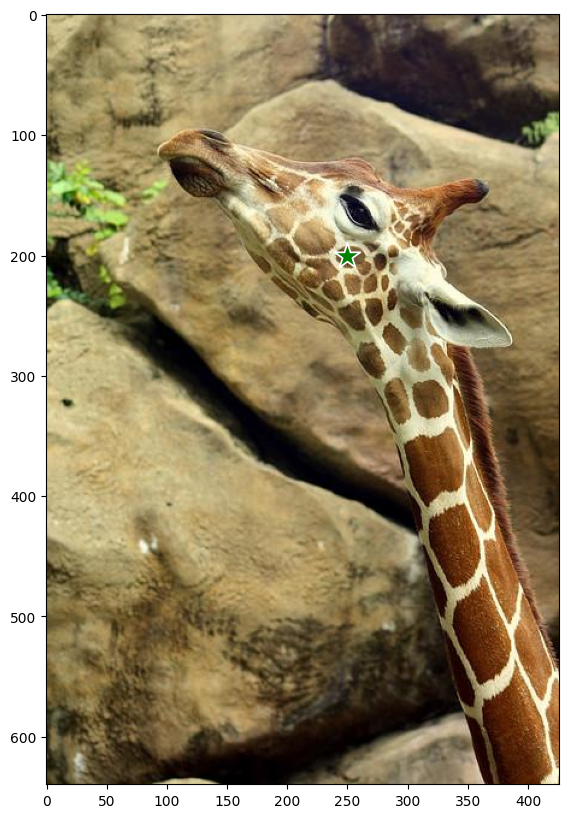

input_points shape : torch.Size([1, 1, 1, 2])
input_points : tensor([[[[400.2347, 320.0000]]]], dtype=torch.float64)
input_labels shape : torch.Size([1, 1, 1])
input_labels : tensor([[[1]]])
pixel_values shape : torch.Size([1, 3, 1024, 1024])
pixel_values : tensor([[[[ 1.4612,  1.4098,  1.3413,  ...,  0.0000,  0.0000,  0.0000],
          [ 1.5125,  1.4612,  1.3927,  ...,  0.0000,  0.0000,  0.0000],
          [ 1.5639,  1.5125,  1.4440,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-1.1247, -1.1418, -1.1589,  ...,  0.0000,  0.0000,  0.0000],
          [-1.1589, -1.1760, -1.1932,  ...,  0.0000,  0.0000,  0.0000],
          [-1.1932, -1.1932, -1.2103,  ...,  0.0000,  0.0000,  0.0000]],

         [[ 1.4132,  1.3606,  1.2906,  ...,  0.0000,  0.0000,  0.0000],
          [ 1.4657,  1.4132,  1.3431,  ...,  0.0000,  0.0000,  0.0000],
          [ 1.5182,  1.4657,  1.3957,  ...,  0.0000,  0.0000,  0.0000],
          ...,
          [-1.2654, -1.2829, -1.3004,  ...,  0.0000,  0.0000, 

In [140]:
image = converted_dataset[0]["img"]
input_points = [[[250, 200]]]
input_labels = [[[1]]]

show_point_box(image, input_points[0], input_labels[0])
inputs = processor(
    image, input_points=input_points, input_labels=input_labels, return_tensors="pt"
)

print("input_points shape :", inputs["input_points"].shape)
print("input_points :", inputs["input_points"])
print("input_labels shape :", inputs["input_labels"].shape)
print("input_labels :", inputs["input_labels"])
print("pixel_values shape :", inputs["pixel_values"].shape)
print("pixel_values :", inputs["pixel_values"])

In [142]:
import torch

In [143]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30 / 255, 144 / 255, 255 / 255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
        masks = masks.squeeze()
    if scores.shape[0] == 1:
        scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(30, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
        mask = mask.cpu().detach()
        axes[i].imshow(np.array(raw_image))
        show_mask(mask, axes[i])
        axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
        axes[i].axis("off")
    plt.show()

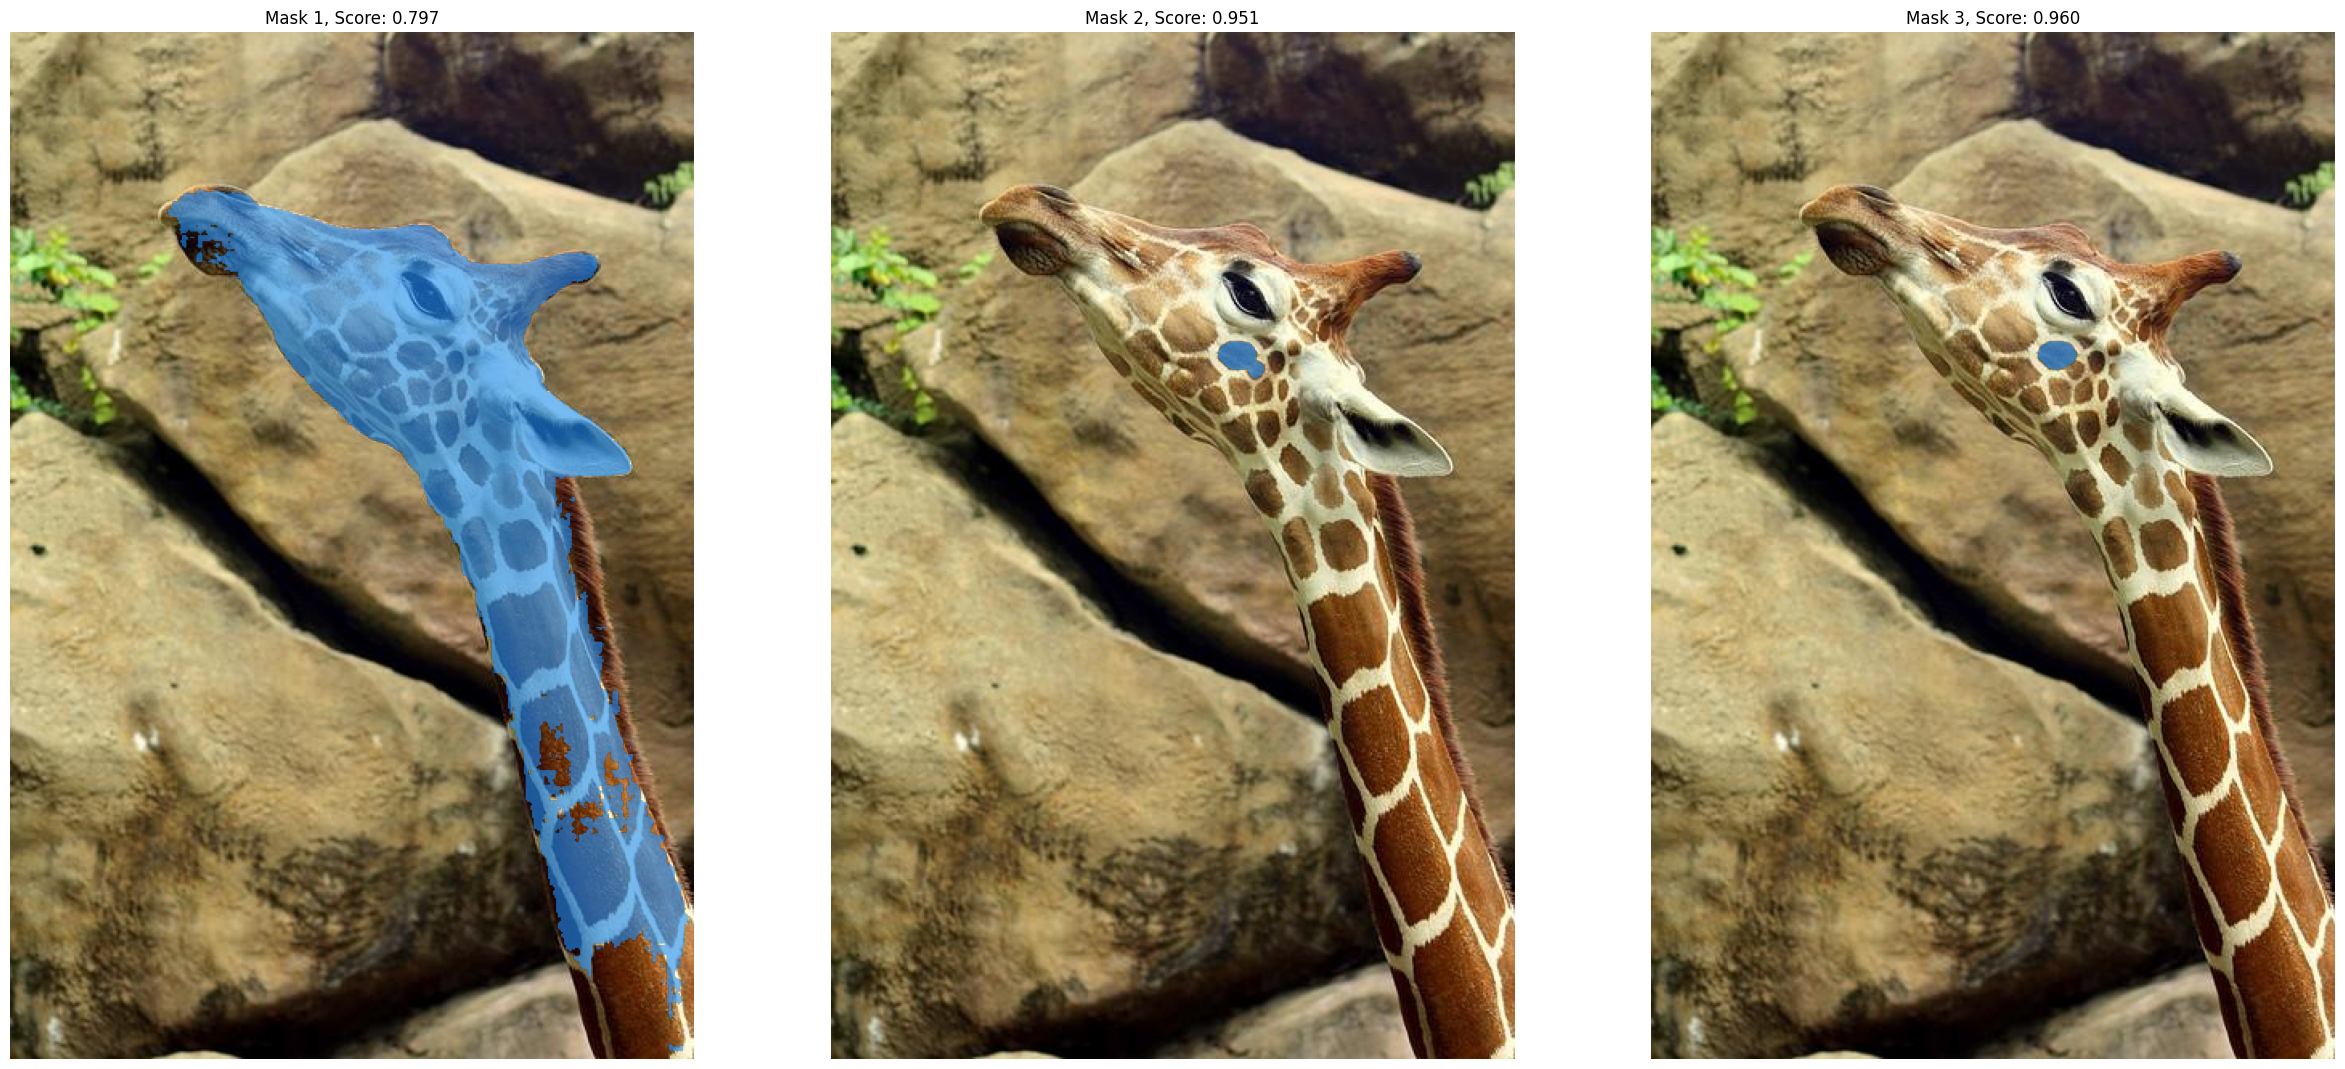

iou_scores shape : torch.Size([1, 1, 3])
iou_scores : tensor([[[0.7971, 0.9507, 0.9603]]])
pred_masks shape : torch.Size([1, 1, 3, 256, 256])
pred_masks : tensor([[[[[ -3.6988,  -3.4369,  -3.1966,  ...,  -4.0645,  -4.0734,
             -3.5750],
           [ -3.6159,  -3.4565,  -3.1221,  ...,  -3.9482,  -3.4807,
             -3.5283],
           [ -3.8523,  -3.3944,  -3.1208,  ...,  -3.8201,  -3.7374,
             -3.7623],
           ...,
           [ -3.2661,  -2.9123,  -2.8053,  ...,  -3.9348,  -3.6503,
             -3.5110],
           [ -3.6191,  -3.0375,  -2.7565,  ...,  -3.6861,  -3.5111,
             -3.2424],
           [ -3.3747,  -2.9888,  -2.8616,  ...,  -3.4819,  -3.2121,
             -3.2320]],

          [[-16.1151, -18.8304, -16.5105,  ..., -17.0530, -15.8617,
            -16.6126],
           [-15.5482, -19.2128, -17.1409,  ..., -17.0094, -17.0313,
            -16.9501],
           [-15.9820, -18.0894, -16.5297,  ..., -16.8648, -17.1188,
            -17.2251],
        

In [144]:
model.eval()
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu(),
)

show_masks_on_image(image, masks[0], outputs.iou_scores)
print("iou_scores shape :", outputs.iou_scores.shape)
print("iou_scores :", outputs.iou_scores)
print("pred_masks shape :", outputs.pred_masks.shape)
print("pred_masks :", outputs.pred_masks)

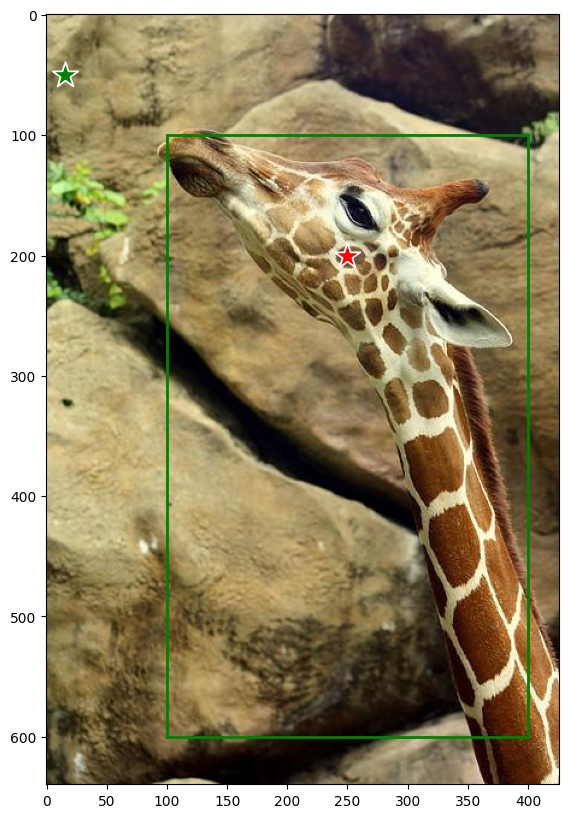

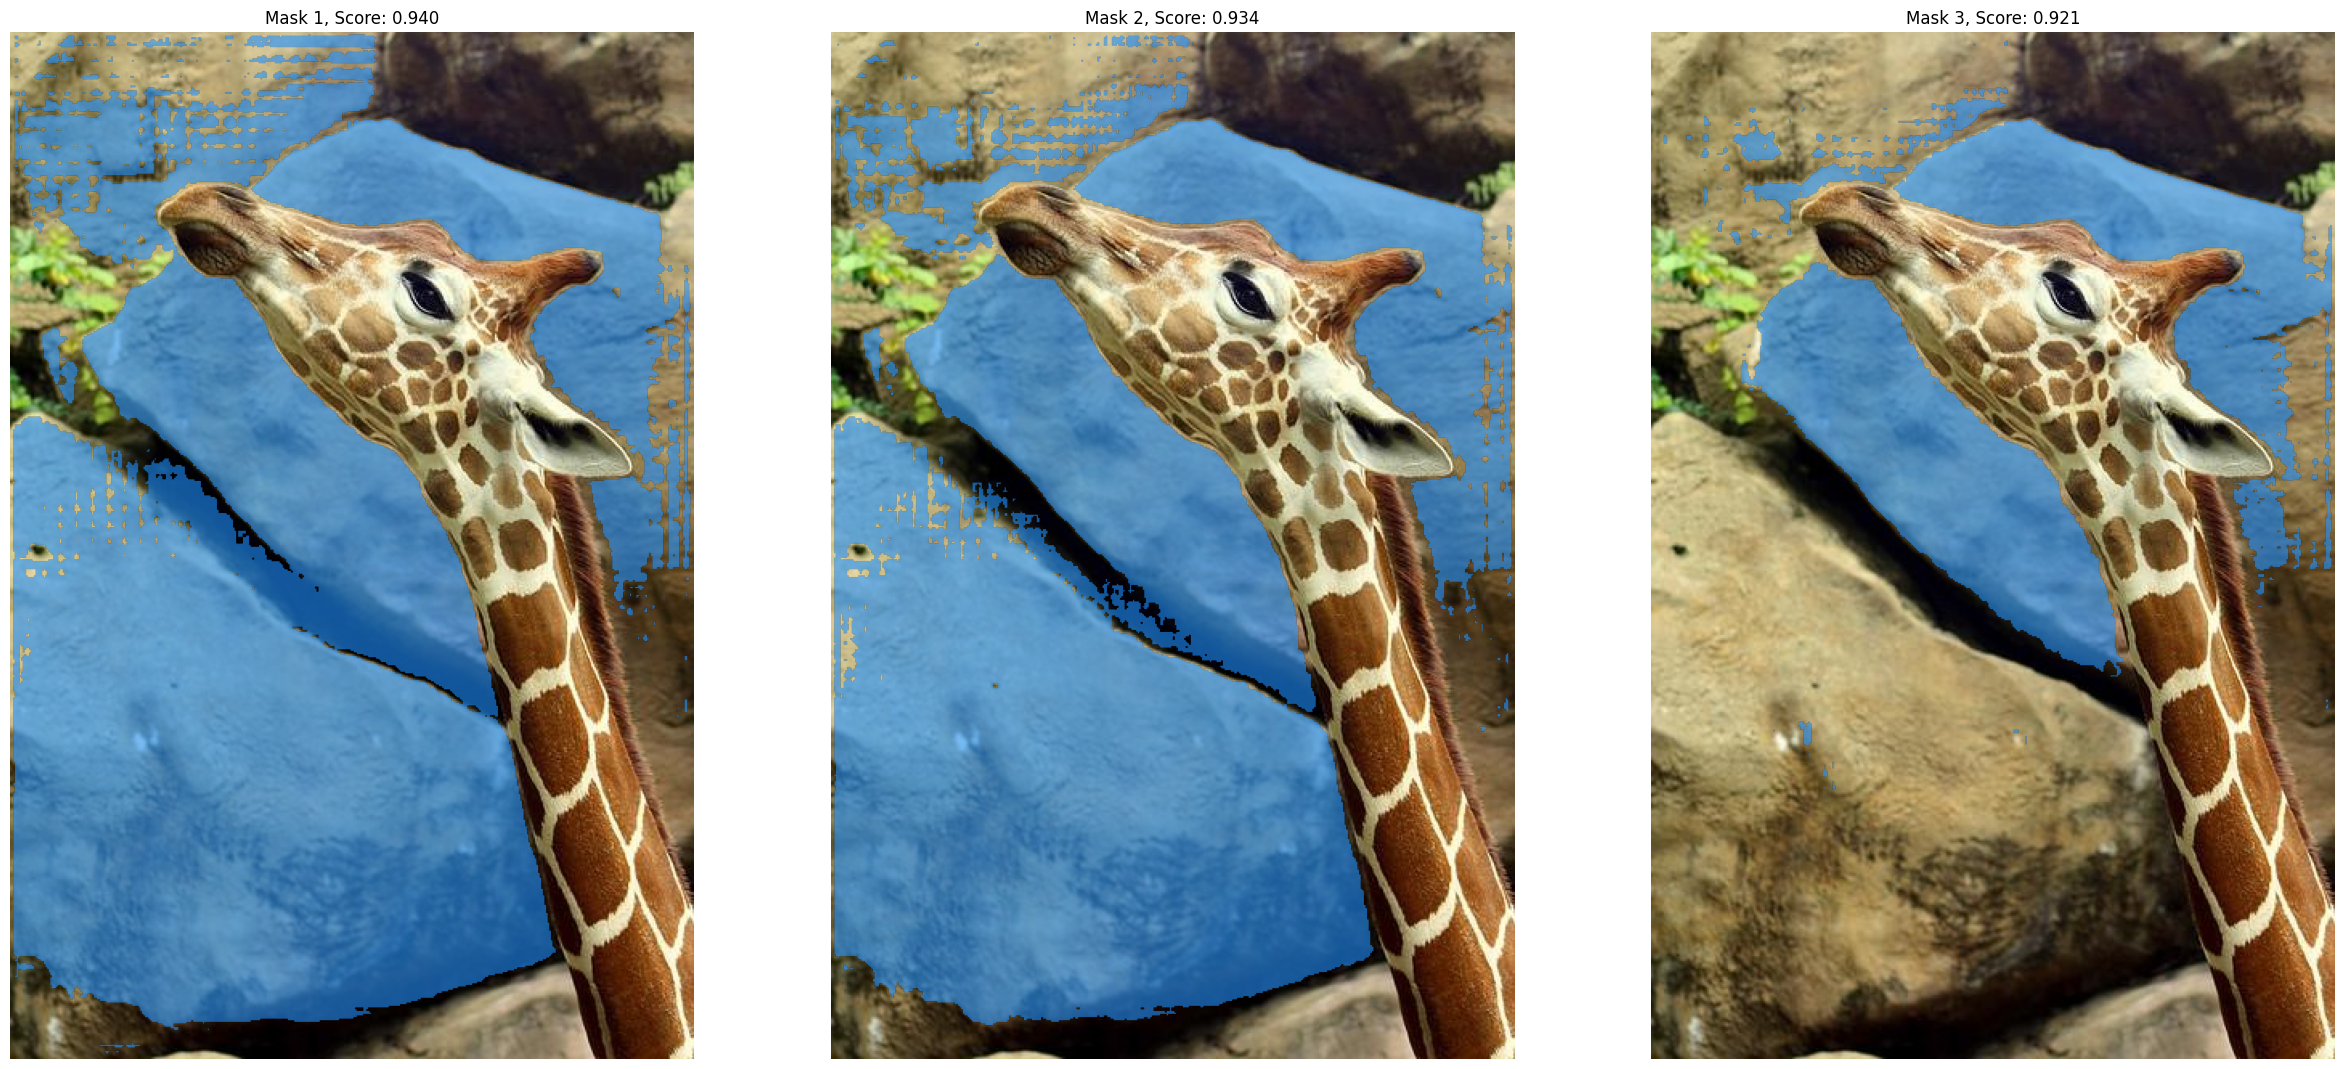

In [145]:
input_points = [[[250, 200], [15, 50]]]
input_labels = [[[0, 1]]]
input_boxes = [[[100, 100, 400, 600]]]

show_point_box(image, input_points[0], input_labels[0], input_boxes[0])
inputs = processor(
    image,
    input_points=input_points,
    input_labels=input_labels,
    input_boxes=input_boxes,
    return_tensors="pt"
)

model.eval()
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu(),
)

show_masks_on_image(image, masks[0], outputs.iou_scores)

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


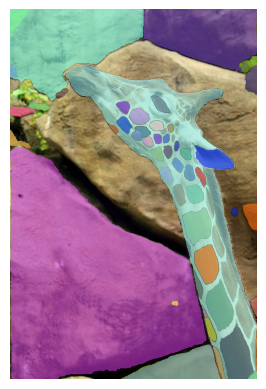

outputs mask의 개수 : 52
outputs scores의 개수 : 52


In [147]:
from transformers import pipeline

generator = pipeline("mask-generation", model=model_name)
outputs = generator(image, points_per_batch=32)

plt.imshow(np.array(image))
ax = plt.gca()
for mask in outputs["masks"]:
    show_mask(mask, ax=ax, random_color=True)
plt.axis("off")
plt.show()

print("outputs mask의 개수 :", len(outputs["masks"]))
print("outputs scores의 개수 :", len(outputs["scores"]))

Hardware accelerator e.g. GPU is available in the environment, but no `device` argument is passed to the `Pipeline` object. Model will be on CPU.


{'score': 0.6905801296234131, 'label': 'giraffe', 'box': {'xmin': 96, 'ymin': 198, 'xmax': 294, 'ymax': 577}}
{'score': 0.6264160871505737, 'label': 'giraffe', 'box': {'xmin': 228, 'ymin': 199, 'xmax': 394, 'ymax': 413}}


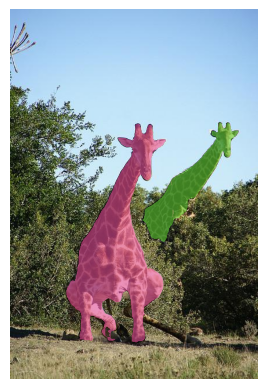

In [148]:
detector = pipeline(
    model="google/owlv2-base-patch16", task="zero-shot-object-detection"
)

image = converted_dataset[24]["img"]
labels = ["dog", "giraffe"]
results = detector(image, candidate_labels=labels, threshold=0.5)

input_boxes = []
for result in results:
    input_boxes.append(
        [
            result["box"]["xmin"],
            result["box"]["ymin"],
            result["box"]["xmax"],
            result["box"]["ymax"]
        ]
    )
    print(result)

inputs = processor(image, input_boxes=[input_boxes], return_tensors="pt")

model.eval()
with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(
    outputs.pred_masks.cpu(),
    inputs["original_sizes"].cpu(),
    inputs["reshaped_input_sizes"].cpu()
)

plt.imshow(np.array(image))
ax = plt.gca()

for mask, iou in zip(masks[0], outputs.iou_scores[0]):
    max_iou_idx = torch.argmax(iou)
    best_mask = mask[max_iou_idx]
    show_mask(best_mask, ax=ax, random_color=True)

plt.axis("off")
plt.show()